Current Working Directory: c:\Users\Kugavathanan\Documents\Centennial\Semester4\Courses\SW Project\PROJECT\Cent Bot Latest\chatbot_project\chatbot
Epoch 1/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0071 - loss: 5.4918 - val_accuracy: 0.0034 - val_loss: 5.3886
Epoch 2/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0175 - loss: 5.2833 - val_accuracy: 0.0069 - val_loss: 5.1066
Epoch 3/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0310 - loss: 4.9736 - val_accuracy: 0.0275 - val_loss: 4.9341
Epoch 4/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0281 - loss: 4.8138 - val_accuracy: 0.0412 - val_loss: 4.7233
Epoch 5/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0437 - loss: 4.6372 - val_accuracy: 0.0619 - val_loss: 4.4937
Epoch 6/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0864 - loss: 4.3726 - val_accuracy: 0.0928 - val_loss: 4.2231
Epoch 7/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0893 - loss:

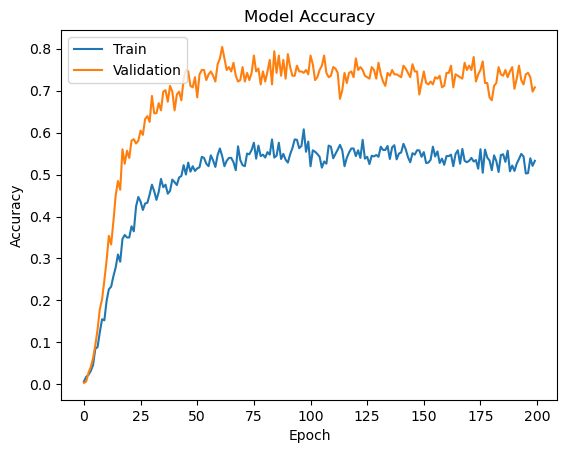

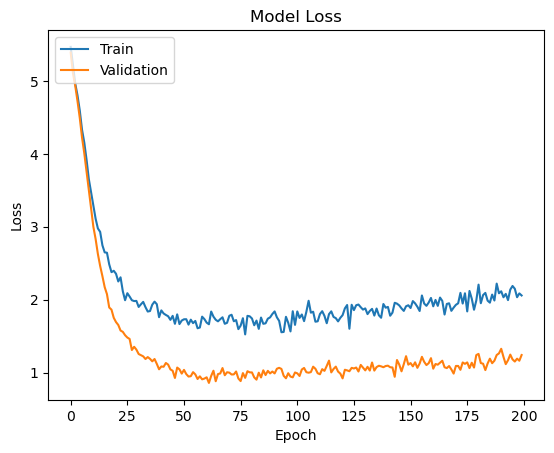

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay
import random
import os

from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import gensim.downloader as api

print("Current Working Directory:", os.getcwd())


class ChatbotModel:
    def __init__(self, intents_path='intents.json'):
        self.intents_path = intents_path
        self.lemmatizer = WordNetLemmatizer()
        self.words = []
        self.classes = []
        self.documents = []
        self.ignore_words = ['?', '!']
        self.model = 
        

    def get_synonyms(word, threshold=0.6):
        synonyms = []
        word = word.lower()
        if word in word_vectors:
            similar_words = word_vectors.similar_by_word(word)
            for similar_word, score in similar_words:
                if score >= threshold:
                    synonyms.append(similar_word)
        return synonyms


    def replace_with_synonyms(sentence):
        tokens = word_tokenize(sentence)
        replaced_sentence = []
        for token in tokens:
            token_lemma = lemmatizer.lemmatize(token)  # Lemmatize the token
            synonyms = get_synonyms(token_lemma)  # Use lemmatized token to find synonyms
            if synonyms:
                length = len(synonyms)
                print(token, ": ",length)
                if(length <= 10):
                
                    for syn in synonyms:
                        replaced_sentence.append(syn)
                else:
                    i =0
                    for i in range(0,10):
                        replaced_sentence.append(syn)

                #replaced_sentence.append(random.choice(synonyms))  # Randomly choose a synonym
            else:
                replaced_sentence.append(token)
        return ' '.join(replaced_sentence)


        

    def preprocess_data():
        nltk.download('punkt')
        nltk.download('wordnet')

        word_vectors = api.load("glove-wiki-gigaword-100")  # Load pre-trained GloVe word vectors
        lemmatizer = WordNetLemmatizer()


    def load_data(self):
        intents = json.loads(open(self.intents_path, encoding='utf-8').read())
        for intent in intents['intents']:
            for pattern in intent['patterns']:
                w = nltk.word_tokenize(pattern)
                self.words.extend(w)
                self.documents.append((w, intent['tag']))
                if intent['tag'] not in self.classes:
                    self.classes.append(intent['tag'])

        self.words = [self.lemmatizer.lemmatize(w.lower()) for w in self.words if w not in self.ignore_words]
        self.words = sorted(list(set(self.words)))
        self.classes = sorted(list(set(self.classes)))

        # Save words and classes to pkl files
        pickle.dump(self.words, open('words.pkl', 'wb'))
        pickle.dump(self.classes, open('classes.pkl', 'wb'))

    def prepare_training_data(self):
        training = []
        output_empty = [0] * len(self.classes)
        for doc in self.documents:
            bag = []
            pattern_words = [self.lemmatizer.lemmatize(word.lower()) for word in doc[0]]
            bag = [1 if w in pattern_words else 0 for w in self.words]
            output_row = list(output_empty)
            output_row[self.classes.index(doc[1])] = 1
            training.append([bag, output_row])

        random.shuffle(training)
        training = np.array(training, dtype=object)
        train_x = list(training[:,0])
        train_y = list(training[:,1])
        return train_x, train_y

    def build_model(self, train_x, train_y):
        self.model = Sequential()
        self.model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(len(train_y[0]), activation='softmax'))

        # Learning rate schedule
        lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.96, staircase=True)
        
        sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    def train(self, train_x, train_y, epochs=200, batch_size=5):
        history = self.model.fit(np.array(train_x), np.array(train_y), epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)
        
        # Save model
        self.model.save('chatbot_model.h5')

        # Plotting training history
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def run(self):
        self.load_data()
        train_x, train_y = self.prepare_training_data()
        self.build_model(train_x, train_y)
        self.train(train_x, train_y)

if __name__ == "__main__":
    chatbot_model = ChatbotModel(intents_path='intents.json')
    chatbot_model.run()
